In [2]:
import sqlite3
import pandas as pd
from propy import PyPro
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import time
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

# Connect to the database and read the data
con = sqlite3.connect("unified_CD2.db")
df = pd.read_sql_query("SELECT seq FROM prod_desc", con)


df

,seq
0,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC
1,KFADENFQLKH
2,KIANGSGSEQDIAEAKI
3,SVQDNFIRF
4,SANTKNDFMRF
...,...
12796,MEWKLNLLLYLALFFFLLFLLFLLLFVVIKQLKNSVANTAGTLQPG...
12797,MGPMKVLLVLLVVMVAAPHIADAWQQPSCSSICDYSCGKSACISYS...
12798,MRTLLVFLLLAIFVAVLIGNVQVEAACKEYWECGAFLFCIEGICVPMIG
12799,MKPSSLTLAFLVVFMMAIMYNSVQAEALADADAEAFAEAGVKELFG...


In [5]:
import pandas as pd
from propy import PyPro
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# List of feature extraction methods
feature_methods = ['GetAAComp', 'GetDPComp', 'GetTPComp']

# Function to extract features for a specific method
def extract_features(sequence, method):
    descriptor = PyPro.GetProDes(sequence)
    try:
        feature = getattr(descriptor, method)()
        return feature
    except AttributeError:
        print(f"AttributeError: Method '{method}' not available for sequence '{sequence}'")
        return None

# Function to apply feature extraction with multithreading and tqdm progress bar
def extract_features_multithreaded(peptides, method, max_workers=4):
    features_list = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_sequence = {executor.submit(extract_features, seq, method): seq for seq in peptides}
        
        # Initialize tqdm progress bar
        with tqdm(total=len(future_to_sequence), desc=f"Extracting {method} Features") as pbar:
            for future in as_completed(future_to_sequence):
                seq = future_to_sequence[future]
                try:
                    feature = future.result()
                    if feature is not None:
                        features_list.append({seq: feature})
                except Exception as e:
                    print(f"Exception for sequence {seq}: {e}")
                finally:
                    pbar.update(1)  # Update progress bar

    return features_list

# Create empty dictionaries for each feature
aacomp_features = {}
dpcomp_features = {}
tpcomp_features = {}

# Extract features for each method
for method in feature_methods:
    features_list = extract_features_multithreaded(df['seq'], method)
    if method == 'GetAAComp':
        aacomp_features = {k: v for d in features_list for k, v in d.items()}
    elif method == 'GetDPComp':
        dpcomp_features = {k: v for d in features_list for k, v in d.items()}
    elif method == 'GetTPComp':
        tpcomp_features = {k: v for d in features_list for k, v in d.items()}

# Create DataFrames from the feature dictionaries
aacomp_df = pd.DataFrame.from_dict(aacomp_features, orient='index')
dpcomp_df = pd.DataFrame.from_dict(dpcomp_features, orient='index')
tpcomp_df = pd.DataFrame.from_dict(tpcomp_features, orient='index')

# Optionally, you may want to rename columns if the dictionary keys are not desired as column names
# aacomp_df.columns = ['Column1', 'Column2', ...]
# dpcomp_df.columns = ['Column1', 'Column2', ...]
# tpcomp_df.columns = ['Column1', 'Column2', ...]

# Optionally, you may want to reset index if sequence identifiers are not desired as index
# aacomp_df.reset_index(inplace=True)
# dpcomp_df.reset_index(inplace=True)
# tpcomp_df.reset_index(inplace=True)

# Optionally, you may want to rename index if sequence identifiers are not desired as index
# aacomp_df.index.name = 'Sequence'
# dpcomp_df.index.name = 'Sequence'
# tpcomp_df.index.name = 'Sequence'

# Optionally, you may want to fill NaN values with zeros if some sequences don't have certain features
# aacomp_df.fillna(0, inplace=True)
# dpcomp_df.fillna(0, inplace=True)
# tpcomp_df.fillna(0, inplace=True)


Extracting GetTPComp Features: 100%|███████████████████████████████████████████| 12801/12801 [1:11:16<00:00,  2.99it/s]


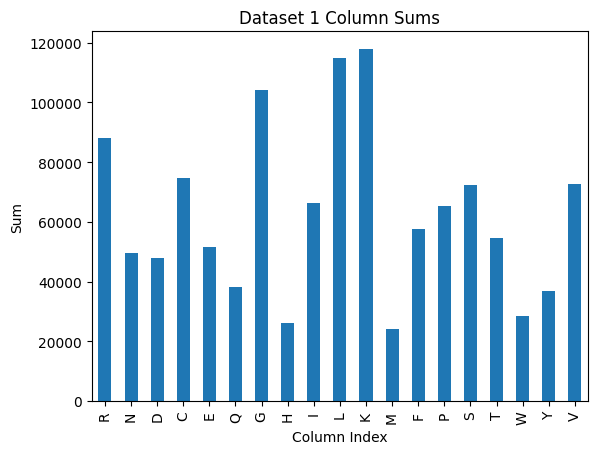

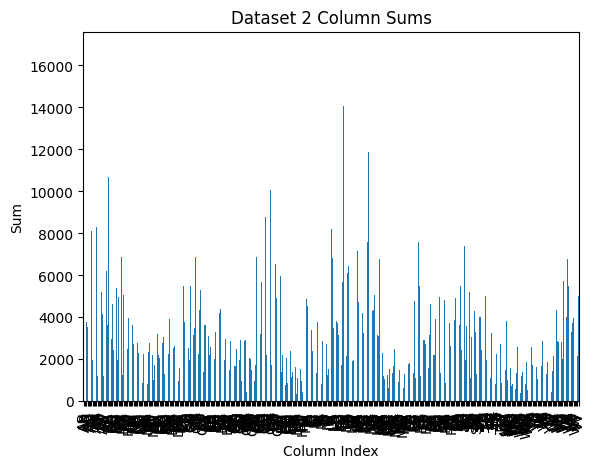

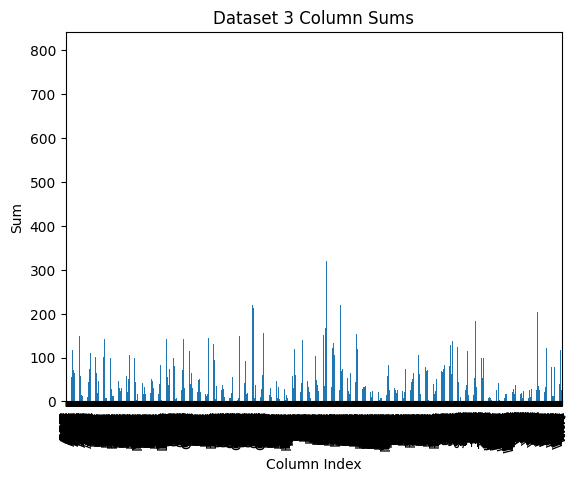

In [6]:
import matplotlib.pyplot as plt

# Assuming aa_df, dp_df, and tp_df are your DataFrames
datasets = [aacomp_df, dpcomp_df, tpcomp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    ax = column_sums.plot(kind='bar', title=f'Dataset {idx} Column Sums')  # Plot the column sums
    ax.set_xlabel('Column Index')
    ax.set_ylabel('Sum')
    ax.set_xticklabels(column_sums.index, rotation=90)  # Rotate x-axis labels vertically
    plt.show()


In [7]:
# Assuming df1, df2, and df3 are your DataFrames
datasets = [aacomp_df, dpcomp_df, tpcomp_df]

# Iterate over each dataset
for idx, df in enumerate(datasets, start=1):
    column_sums = df.iloc[:, 1:].sum()  # Calculate the sum of values in each column excluding the first column
    highest_sums = column_sums.nlargest(3)  # Get the top 3 columns with the highest sums
    print(f"Top columns in dataset {idx}:")
    print(highest_sums)


Top columns in dataset 1:
K    117883.429
L    114862.239
G    104049.425
dtype: float64
Top columns in dataset 2:
KK    16770.98
LL    14088.52
LK    13002.44
dtype: float64
Top columns in dataset 3:
LKK    801
KKL    615
LLL    602
dtype: int64
